# Obama & Trump Tweets - Part 4

- In this notebook, I will prepare DataFrame for Machine Learning
- I will use **tweets** as the only feature in this notebook (
- I will use **TfidfVectorizer** for text vectorizing with **ngram(1,2)**
- I will use multiple classifiers, evaluate them, select model and tune its parameters
- I will use final model, train it on all dataset and predict new tweets

# Import Libraries

In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV

import xgboost as xgb
import lightgbm as lgb

# Set Default Settings

In [2]:
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')

# Import Pickled File

In [3]:
# Import pickled file
df = pd.read_pickle('Jan19_Trump_Obama_Tweets_ML_Ready_Final.pickle')

In [4]:
df.head(2)

,date,favorite_counts,retweet_counts,hashtags,mentions,tweets_length,tweets_spaces,tweets_uppercase,tweets_punctuations,tweets_questionmark,tweets_exclamation_mark,polarity,subjectivity,polarity_status,subjectivity_status,is_neutral,is_positive,is_negative,part_of_day,is_early,is_morning,is_noon,is_evening,is_midnight,is_norp,is_time,is_org,is_gpe,is_loc,is_product,is_workart,is_fac,is_noun,is_pron,is_adv,is_propn,is_verb,is_intj,month,day,week_day,week_day_name,hour,clean_tweets,profile
0,2018-12-22 02:49:05,61773,17110,NaN,NaN,45,7,37,1,0,1,1.00,0.75,Very Positive,Very Subjective,0,1,0,Mid Night,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,3,2,0,12,22,5,Saturday,2,great country border security,0
1,2018-12-22 00:16:55,66758,10652,NaN,NaN,77,11,7,1,0,1,0.44,0.55,Positive,Subjective,0,1,0,Mid Night,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,6,1,0,12,22,5,Saturday,0,wish supreme court justice ruth bad ginsburg s...,0


# Prepare Dataset for ML
1. Seperate features from labels
2. Seperate training and testing datasets
3. Vectorize tweets 

In [7]:
def process_data(data, feature, target):
    
    shuf_df = shuffle(data)                             # Shuffle DataFrame
    shuf_df.reset_index(drop = True, inplace = True)    # Reset DataFrame index
    
    X = data[feature]
    y = data[target]
    
    return X, y

X, y = process_data( data    = df, 
                     feature = ['clean_tweets'], 
                     target  = ['profile'] )

In [8]:
# Split train, test dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 42)

In [9]:
# Check shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train.values.shape, X_test.values.shape, y_train.values.ravel().shape, y_test.values.ravel().shape)

(508, 1) (127, 1) (508, 1) (127, 1)
(508, 1) (127, 1) (508,) (127,)


In [10]:
# Initiate TFIDF Vect
tfidf_vect = TfidfVectorizer(ngram_range = (1,3), stop_words = 'english', sublinear_tf = True)

# Fit & transform the X_train
tfidfVect_train    = tfidf_vect.fit_transform(X_train.clean_tweets)
tfidfVect_train_df = pd.DataFrame(tfidfVect_train.toarray(), columns = tfidf_vect.get_feature_names())
# Transform the X_test
tfidfVect_test     = tfidf_vect.transform(X_test.clean_tweets)
tfidfVect_test_df  = pd.DataFrame(tfidfVect_test.toarray(), columns = tfidf_vect.get_feature_names())

# Evaluate Models
1. Evaluate models
2. Display results
3. Select best model based on **Accuracy**, **Precision** and **F1 Score**
4. Tune model's parameter using GridSearchCV
5. Train model on all dataset
6. Predict new tweets samples

In [34]:
# Initiate lists 
model_name_list = []
accuracyScore_list = []
recallScore_list = []
precisionScore_list = []
rocAucScore_list = []
f1Score_list = []

def evaluate_classifier(model, Xtrain, Xtest, ytrain, ytest):
    # Initiate the Naive Bayes 'MultinomialNB' classifier
    clf = model[1]

    # Fit classifier with the X_train_tfidf, y_train
    clf.fit(Xtrain, ytrain)

    # Store predicted values ub y_pred
    y_pred = clf.predict(Xtest)
    
    accuracyScore  = accuracy_score(ytest, y_pred)
    recallScore    = recall_score(ytest, y_pred)
    precisionScore = precision_score(ytest, y_pred)
    rocAucScore    = roc_auc_score(ytest, y_pred)
    f1Score        = f1_score(ytest, y_pred)

    model_name_list.append(model[0])
    accuracyScore_list.append(accuracyScore)
    recallScore_list.append(recallScore)
    precisionScore_list.append(precisionScore)
    rocAucScore_list.append(rocAucScore)
    f1Score_list.append(f1Score)
    
    print('Accuracy Score: {}\n\n'.format(round(accuracyScore * 100),1))

    print('Confusion Matrix:')
    sns.heatmap(confusion_matrix(ytest, y_pred), annot = True, xticklabels = ["Trump","Obama"], yticklabels = ["Obama", "Trump"])
    plt.show()

    print('\n\nClassification Report: \n{}\n'.format(classification_report(ytest, y_pred)))

Accuracy Score: 95.0


Confusion Matrix:


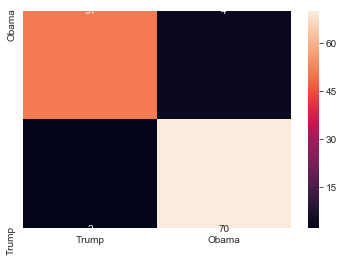



Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        55
           1       0.95      0.97      0.96        72

    accuracy                           0.95       127
   macro avg       0.95      0.95      0.95       127
weighted avg       0.95      0.95      0.95       127




In [35]:
# Evaluate Naive Bayes 'MultinomialNB' classifier
evaluate_classifier( model  = ['MultinomialNB', MultinomialNB(alpha= 0.01)], 
                     Xtrain = tfidfVect_train_df.values, 
                     Xtest  = tfidfVect_test_df.values, 
                     ytrain = y_train.values.ravel(), 
                     ytest  = y_test.values.ravel())

Accuracy Score: 85.0


Confusion Matrix:


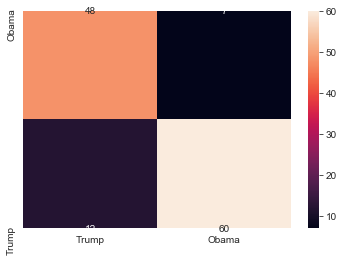



Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        55
           1       0.90      0.83      0.86        72

    accuracy                           0.85       127
   macro avg       0.85      0.85      0.85       127
weighted avg       0.85      0.85      0.85       127




In [36]:
# Evaluate XGBoost classifier
evaluate_classifier( model  = ['XGBoost', xgb.XGBClassifier(learning_rate = 0.5)], 
                     Xtrain = tfidfVect_train_df.values, 
                     Xtest  = tfidfVect_test_df.values, 
                     ytrain = y_train.values.ravel(), 
                     ytest  = y_test.values.ravel())

Accuracy Score: 78.0


Confusion Matrix:


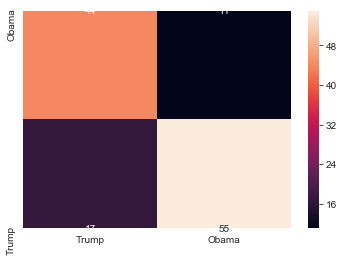



Classification Report: 
              precision    recall  f1-score   support

           0       0.72      0.80      0.76        55
           1       0.83      0.76      0.80        72

    accuracy                           0.78       127
   macro avg       0.78      0.78      0.78       127
weighted avg       0.78      0.78      0.78       127




In [37]:
# Evaluate LightGBM classifier
evaluate_classifier( model  = ['LightGBM', lgb.LGBMClassifier(learning_rate = 0.5)], 
                     Xtrain = tfidfVect_train_df.values, 
                     Xtest  = tfidfVect_test_df.values, 
                     ytrain = y_train.values.ravel(), 
                     ytest  = y_test.values.ravel())

Accuracy Score: 91.0


Confusion Matrix:


/Users/haithamalabadla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


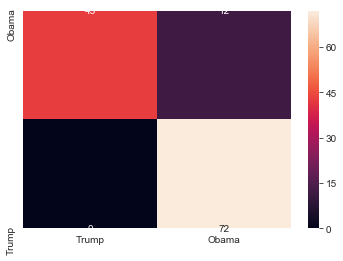



Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        55
           1       0.86      1.00      0.92        72

    accuracy                           0.91       127
   macro avg       0.93      0.89      0.90       127
weighted avg       0.92      0.91      0.90       127




In [14]:
# Evaluate LogisticRegression classifier
evaluate_classifier( model  = ['LogisticRegression', LogisticRegression()], 
                     Xtrain = tfidfVect_train_df.values, 
                     Xtest  = tfidfVect_test_df.values, 
                     ytrain = y_train.values.ravel(), 
                     ytest  = y_test.values.ravel())

Accuracy Score: 98.0


Confusion Matrix:


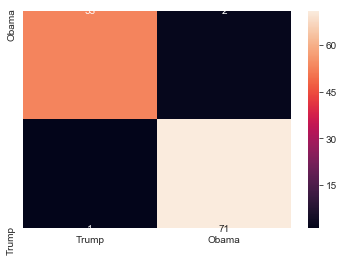



Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        55
           1       0.97      0.99      0.98        72

    accuracy                           0.98       127
   macro avg       0.98      0.97      0.98       127
weighted avg       0.98      0.98      0.98       127




In [15]:
# Evaluate SVC classifier
evaluate_classifier( model  = ['SVC', SVC(kernel = 'linear')], 
                     Xtrain = tfidfVect_train_df.values, 
                     Xtest  = tfidfVect_test_df.values, 
                     ytrain = y_train.values.ravel(), 
                     ytest  = y_test.values.ravel())

Accuracy Score: 91.0


Confusion Matrix:


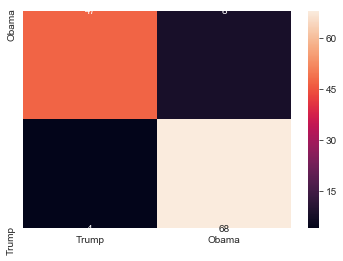



Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.85      0.89        55
           1       0.89      0.94      0.92        72

    accuracy                           0.91       127
   macro avg       0.91      0.90      0.90       127
weighted avg       0.91      0.91      0.91       127




In [16]:
# Evaluate LinearSVC classifier
evaluate_classifier( model  = ['LinearSVC', LinearSVC(penalty = 'l1', dual = False)], 
                     Xtrain = tfidfVect_train_df.values, 
                     Xtest  = tfidfVect_test_df.values, 
                     ytrain = y_train.values.ravel(), 
                     ytest  = y_test.values.ravel())

In [17]:
# Assemble scores from lists to dataframe
def assemble_scores():

    results_dict = { 'Model': model_name_list,
                     'Accuracy_Score': accuracyScore_list,
                     'Recall_Score': recallScore_list,
                     'Precision_Score': precisionScore_list,
                     'ROC_AUC_Score': rocAucScore_list,
                     'F1_Score': f1Score_list }

    results_df = pd.DataFrame(results_dict)
    
    return results_df

# Call assemble_scoes function to assemble scores into dataframe
results_df = assemble_scores()

In [18]:
results_df

,Model,Accuracy_Score,Recall_Score,Precision_Score,ROC_AUC_Score,F1_Score
0,MultinomialNB,0.952756,0.972222,0.945946,0.949747,0.958904
1,XGBoost,0.850394,0.833333,0.895522,0.853030,0.863309
2,LightGBM,0.779528,0.763889,0.833333,0.781944,0.797101
3,LogisticRegression,0.905512,1.000000,0.857143,0.890909,0.923077
4,SVC,0.976378,0.986111,0.972603,0.974874,0.979310
5,LinearSVC,0.905512,0.944444,0.894737,0.899495,0.918919


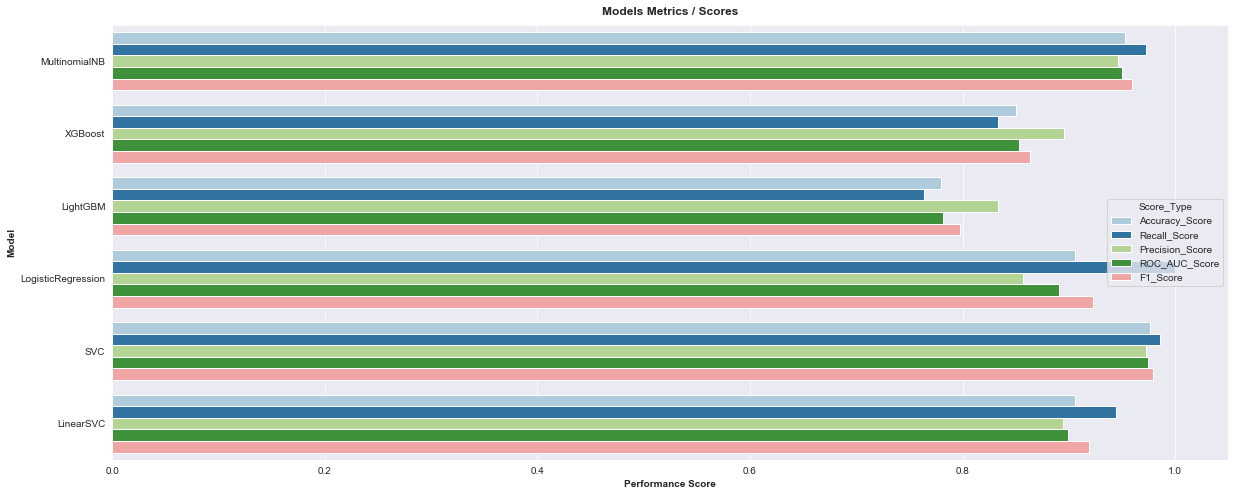

In [19]:
# Change the shape of the dataframe using pd.melt
results_melted_df = pd.melt(frame = results_df, id_vars = ['Model'], value_vars = ['Accuracy_Score', 'Recall_Score', 'Precision_Score', 'ROC_AUC_Score', 'F1_Score'], var_name = 'Score_Type', value_name = 'Score')

# Plot scores againt models
plt.figure(figsize= (20,8))

_ = sns.barplot( data = results_melted_df, x = 'Score', y = 'Model', hue = 'Score_Type', palette= "Paired")

_.set_title('Models Metrics / Scores', pad = 10, weight= 'bold')
_.set_xlabel('Performance Score', weight= 'bold')
_.set_ylabel('Model', weight= 'bold')

plt.show()

In [12]:
# Initiate TFIDF Vect
tfidf_vectorize = TfidfVectorizer(ngram_range = (1,3), stop_words = 'english', sublinear_tf = True)

# Fit & transform the 
tfidfVect_X    = tfidf_vectorize.fit_transform(X.clean_tweets)
tfidfVect_X_df = pd.DataFrame(tfidfVect_X.toarray(), columns = tfidf_vectorize.get_feature_names())

# MultinomialNB Tunning

In [13]:
# GridSearchCV
cls_nb = MultinomialNB()

para_grid = { 'alpha': [0.001, 0.01, 0.1, 0.5, 1],
              'fit_prior' : [False, True] }

cls_nb_gscv = GridSearchCV( iid = False, estimator = cls_nb, param_grid = para_grid, cv = 10, return_train_score = True, n_jobs = -1 )
cls_nb_gscv_fit = cls_nb_gscv.fit(tfidfVect_X_df.values, y.values.ravel())

cls_nb_results_df = pd.DataFrame(cls_nb_gscv_fit.cv_results_)

/Users/haithamalabadla/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [14]:
cls_nb_results_df.sort_values('mean_test_score', ascending = False)[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_prior,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
7,0.296191,0.023213,0.005221,0.002017,0.5,True,"{'alpha': 0.5, 'fit_prior': True}",0.921875,0.984375,0.921875,0.937500,0.875000,0.921875,0.937500,0.809524,0.935484,0.935484,0.918049,0.044089,1,0.996497,0.996497,0.996497,0.996497,0.996497,0.996497,0.996497,0.998252,0.998255,0.996510,0.996850,0.000702
8,0.271976,0.010759,0.004382,0.000840,1,False,"{'alpha': 1, 'fit_prior': False}",0.968750,0.953125,0.921875,0.875000,0.859375,0.875000,0.921875,0.857143,0.967742,0.951613,0.915150,0.042662,2,0.998249,0.998249,0.998249,0.998249,0.998249,1.000000,0.998249,0.998252,0.998255,0.998255,0.998425,0.000525
6,0.340876,0.010389,0.005692,0.002376,0.5,False,"{'alpha': 0.5, 'fit_prior': False}",0.968750,0.953125,0.906250,0.875000,0.843750,0.906250,0.875000,0.857143,0.983871,0.951613,0.912075,0.047030,3,0.998249,0.998249,0.998249,0.998249,0.998249,1.000000,0.998249,0.998252,0.998255,0.998255,0.998425,0.000525
5,0.365201,0.038453,0.007112,0.003291,0.1,True,"{'alpha': 0.1, 'fit_prior': True}",0.953125,0.953125,0.906250,0.921875,0.843750,0.921875,0.859375,0.809524,0.935484,0.951613,0.905600,0.048219,4,0.996497,0.996497,0.996497,0.996497,0.996497,0.996497,0.996497,0.998252,0.998255,0.996510,0.996850,0.000702
1,0.353184,0.051893,0.008516,0.003668,0.001,True,"{'alpha': 0.001, 'fit_prior': True}",0.953125,0.968750,0.859375,0.906250,0.828125,0.921875,0.875000,0.841270,0.903226,0.967742,0.902474,0.048472,5,0.996497,0.996497,0.996497,0.996497,0.996497,0.996497,0.996497,0.998252,0.998255,0.996510,0.996850,0.000702


In [15]:
print('Best Score: {}\nBest Parameters: {}'.format(round(cls_nb_gscv_fit.best_score_ *100, 1) , cls_nb_gscv_fit.best_params_))

Best Score: 91.8
Best Parameters: {'alpha': 0.5, 'fit_prior': True}


# SVC Tunning

In [41]:
# GridSearchCV
cls_svc = SVC()

para_grid = { 'C': [0.001, 0.01, 0.1, 1, 10],
              'kernel' : ['linear', 'rbf'],
              'gamma'  : [0.1, 1, 10, 100]}

cls_svc_gscv = GridSearchCV( iid = False, estimator = cls_svc, param_grid = para_grid, cv = 10, return_train_score = True)
cls_svc_gscv_fit =cls_svc_gscv.fit(tfidfVect_X_df.values, y.values.ravel())

cls_svc_results_df = pd.DataFrame(cls_svc_gscv_fit.cv_results_)

KeyboardInterrupt: 

Generally speaking, SVC perform better in all metrixes compared to MultinomialNB by fractions however, comparing the time it takes to fit/ optimize.... etc. The MultinomialNB takes just few seconds (around 3 to 4 second) unlike the SVC which takes more than 25 mins. Therefore, I would go for the MultinomialNB model. 

**NOTE**<br>
For this project I will not add the extracted additional features, I will use the TFIDF features created as my input only for the model.

# Predict New Tweets Samples

In [17]:
T1 = 'Nancy just said she “just doesn’t understand why?” Very simply, without a Wall it all doesn’t work. Our Country has a chance to greatly reduce Crime, Human Trafficking, Gangs and Drugs. Should have been done for decades. We will not Cave!'
T2 = 'Without a Wall there cannot be safety and security at the Border or for the U.S.A. BUILD THE WALL AND CRIME WILL FALL!'
T3 = 'The Fake News Media loves saying “so little happened at my first summit with Kim Jong Un.” Wrong! After 40 years of doing nothing with North Korea but being taken to the cleaners, & with a major war ready to start, in a short 15 months, relationships built, hostages & remains....'

O1 = 'I’ve always drawn inspiration from what Dr. King called life’s most persistent and urgent question: "What are you doing for others?" Let’s honor his legacy by standing up for what is right in our communities and taking steps to make a positive impact on the world.'
O2 = 'In 2018 people stepped up and showed up like never before. Keep it up in 2019. We’ve got a lot of work to do, and I’ll be right there with you. Happy New Year, everybody!'
O3 = 'I hope you find inspiration in the stories of Dejah, Moussa, Sandor, Hong and Jonny. Their journeys began with a decision to build the better future they wanted to see. The same is true for you. What matters isn’t the size of the step you take; what matters is that you take it.'

Q3 = 'Nadler just said that I “pressured Ukraine to interfere in our 2020 Election.” Ridiculous, and he knows that is not true. Both the President & Foreign Minister of Ukraine said, many times, that there “WAS NO PRESSURE.” Nadler and the Dems know this, but refuse to acknowledge!'

tweets_list = [T1, O1, T2, O2, T3, O3, Q3]

for indx, tweet in enumerate(tweets_list):
    result = cls_nb_gscv_fit.predict(tfidf_vectorize.transform([tweet])).item()
    print(indx, 'Donald Trump' if result == 0 else 'Barak Obama')


0 Donald Trump
1 Barak Obama
2 Donald Trump
3 Barak Obama
4 Donald Trump
5 Barak Obama
6 Donald Trump


In [18]:
import joblib

In [19]:
joblib.dump(cls_nb_gscv_fit, 'ot_classifier.sav')

['ot_classifier.sav']

In [20]:
joblib.dump(tfidf_vectorize, 'tfidf_transformer.sav')


['tfidf_transformer.sav']